In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
data = pd.read_table('../data/u.data')

In [3]:
data.head()

,user,event,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


### Pre-processing the data

#### 3.1 Finding all unique values from data for events and users

In [4]:
users = data['user'].unique()
events = data['event'].unique()

events[:10], users[:10]

(array([242, 302, 377,  51, 346, 474, 265, 465, 451,  86]),
 array([196, 186,  22, 244, 166, 298, 115, 253, 305,   6]))

#### 3.2 Assigning idx's to unique users and events

In [5]:
user_to_idx = {user: idx for idx, user in enumerate(users)}
event_to_idx = {event: idx for idx, event in enumerate(events)}
idx_to_user = {idx: user for user, idx in user_to_idx.items()} # For reverse lookup
idx_to_event = {idx: event for event, idx in event_to_idx.items()} # For reverse lookup

for key, value in user_to_idx.items():
    if value == 0:
        print(f'User: {key}, assigned index: {value}')

for key, value in event_to_idx.items():
    if value == 0:
        print(f'Event: {key}, assigned index: {value}')

User: 196, assigned index: 0
Event: 242, assigned index: 0


#### 3.3 Using the idx to add column in dataframe

In [6]:
data['user_idx'] = data['user'].map(user_to_idx)
data['event_idx'] = data['event'].map(event_to_idx)

data.head()

,user,event,rating,timestamp,user_idx,event_idx
0,196,242,3,881250949,0,0
1,186,302,3,891717742,1,1
2,22,377,1,878887116,2,2
3,244,51,2,880606923,3,3
4,166,346,1,886397596,4,4


#### 3.4 Splitting the data into training and testing

In [7]:
train_data, test_data = train_test_split(data, test_size=0.2, random_state=21, shuffle=True)
train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=21, shuffle=True)
len(train_data), len(val_data), len(test_data)

(60000, 20000, 20000)

In [8]:
train_data.head()

,user,event,rating,timestamp,user_idx,event_idx
38585,519,878,5,884545961,521,995
57464,758,121,2,881978864,752,403
16125,277,872,3,879543768,261,223
16767,343,147,4,876402814,339,452
90032,686,50,4,879545413,684,357


In [9]:
test_data.head()

,user,event,rating,timestamp,user_idx,event_idx
39544,591,235,3,891039676,582,181
24258,450,689,3,882216026,442,890
23442,13,462,5,882140487,58,299
35853,159,1013,4,880557170,233,1013
35928,515,307,4,887659123,507,104


#### 3.5 Creating the train and test dataloaders

In [10]:
train_dataloader = DataLoader(train_data[['user_idx', 'event_idx', 'rating']].values, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_data[['user_idx', 'event_idx', 'rating']].values, batch_size=64, shuffle=False)
test_dataloader = DataLoader(test_data[['user_idx', 'event_idx', 'rating']].values, batch_size=64, shuffle=False)

In [11]:
for batch in train_dataloader:
    print('Example batch: ', batch[:10])
    print()
    print('Len of a batch: ', len(batch))
    break

Example batch:  tensor([[111, 663,   3],
        [310, 101,   4],
        [442, 124,   3],
        [258, 280,   5],
        [404, 244,   3],
        [ 11, 432,   2],
        [939,  24,   4],
        [862, 506,   5],
        [ 55, 748,   4],
        [131, 251,   3]])

Len of a batch:  64


In [12]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(VariationalAutoencoder, self).__init__()
        
        hidden_dim = min(input_dim, 1024)  # Limit hidden dimension size
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.LayerNorm(hidden_dim // 2),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(hidden_dim // 2, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim // 2, latent_dim)
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim // 2),
            nn.LayerNorm(hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )
    
    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_logvar(h)
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        return self.decoder(z)
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


In [13]:
def vae_loss(recon_x, x, mu, logvar, beta=0.1):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + beta * KLD

def train_vae(vae, dataloader, num_epochs=20, lr=1e-4):
    optimizer = optim.Adam(vae.parameters(), lr=lr, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)
    
    for epoch in range(num_epochs):
        total_loss = 0
        for batch in dataloader:
            optimizer.zero_grad()
            recon_batch, mu, logvar = vae(batch)
            loss = vae_loss(recon_batch, batch, mu, logvar)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(vae.parameters(), 1.0)  # Gradient clipping
            optimizer.step()
            total_loss += loss.item()
        
        avg_loss = total_loss / len(dataloader)
        scheduler.step(avg_loss)
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}')


In [14]:
class NCF(nn.Module):
    def __init__(self, num_users, num_items, embedding_dim=96, hidden_dim=64):
        super(NCF, self).__init__()
        self.user_vae = VariationalAutoencoder(num_users, embedding_dim)
        self.item_vae = VariationalAutoencoder(num_items, embedding_dim)
        self.fc1 = nn.Linear(embedding_dim * 2, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.fc3 = nn.Linear(hidden_dim // 2, 1)
        self.dropout = nn.Dropout(0.3)
        
    def forward(self, user, item):
        user_onehot = F.one_hot(user, num_classes=self.user_vae.encoder[0].in_features).float()
        item_onehot = F.one_hot(item, num_classes=self.item_vae.encoder[0].in_features).float()
        
        _, user_embedded, _ = self.user_vae(user_onehot)
        _, item_embedded, _ = self.item_vae(item_onehot)
        
        x = torch.cat([user_embedded, item_embedded], dim=-1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [15]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [16]:

def train(model, train_dataloader, val_dataloader, optimizer, criterion, device, num_epochs=20):
    model.train()
    early_stopper = EarlyStopper(patience=5, min_delta=0.001)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)
    l2 = 1e-3
    
    train_losses = []
    val_losses = []
    train_maes = []
    val_maes = []
    train_rmses = []
    val_rmses = []

    for epoch in range(num_epochs):
        total_loss = 0
        total_val_loss = 0
        total_mae = 0
        total_val_mae = 0
        total_rmse = 0
        total_val_rmse = 0

        for batch in train_dataloader:
            user, item, target = batch[:, 0].to(device), batch[:, 1].to(device), batch[:, 2].float().to(device)
            optimizer.zero_grad()
            output = model(user, item).squeeze()
            loss = criterion(output, target) + l2 * sum(p.pow(2.0).sum() for p in model.parameters())
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # Gradient clipping
            optimizer.step()
            total_loss += loss.item()

            # Calculate MAE and RMSE for training
            mae = torch.abs(output - target).mean().item()
            rmse = torch.sqrt(((output - target) ** 2).mean()).item()
            total_mae += mae
            total_rmse += rmse
        
        model.eval()
        with torch.no_grad():
            for batch in val_dataloader:
                user, item, target = batch[:, 0].to(device), batch[:, 1].to(device), batch[:, 2].float().to(device)
                output = model(user, item).squeeze()
                val_loss = criterion(output, target)
                total_val_loss += val_loss.item()

                # Calculate MAE and RMSE for validation
                val_mae = torch.abs(output - target).mean().item()
                val_rmse = torch.sqrt(((output - target) ** 2).mean()).item()
                total_val_mae += val_mae
                total_val_rmse += val_rmse

        avg_train_loss = total_loss / len(train_dataloader)
        avg_val_loss = total_val_loss / len(val_dataloader)
        avg_train_mae = total_mae / len(train_dataloader)
        avg_val_mae = total_val_mae / len(val_dataloader)
        avg_train_rmse = total_rmse / len(train_dataloader)
        avg_val_rmse = total_val_rmse / len(val_dataloader)
        
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        train_maes.append(avg_train_mae)
        val_maes.append(avg_val_mae)
        train_rmses.append(avg_train_rmse)
        val_rmses.append(avg_val_rmse)
        
        scheduler.step(avg_val_loss)

        if early_stopper.early_stop(avg_val_loss):
            print(f"Early stopping at epoch {epoch+1}")
            break
        
        print(f'Epoch: {epoch+1} -> Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Train MAE: {avg_train_mae:.4f} | Val MAE: {avg_val_mae:.4f} | Train RMSE: {avg_train_rmse:.4f} | Val RMSE: {avg_val_rmse:.4f}')

    return train_losses, val_losses, train_maes, val_maes, train_rmses, val_rmses

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_users = len(users)
num_items = len(events)
embedding_dim = 64

In [18]:
user_vae = VariationalAutoencoder(num_users, embedding_dim).to(device)
item_vae = VariationalAutoencoder(num_items, embedding_dim).to(device)

user_dataloader = DataLoader(torch.eye(num_users).to(device), batch_size=128, shuffle=True)
item_dataloader = DataLoader(torch.eye(num_items).to(device), batch_size=128, shuffle=True)

In [19]:
print("Training User VAE:")
train_vae(user_vae, user_dataloader)
print("\nTraining Item VAE:")
train_vae(item_vae, item_dataloader)

Training User VAE:
Epoch 1/20, Loss: 70319.1274
Epoch 2/20, Loss: 52181.9517
Epoch 3/20, Loss: 37823.0879
Epoch 4/20, Loss: 26376.6836
Epoch 5/20, Loss: 17996.7709
Epoch 6/20, Loss: 12301.0218
Epoch 7/20, Loss: 8463.3616
Epoch 8/20, Loss: 5892.5544
Epoch 9/20, Loss: 4187.6408
Epoch 10/20, Loss: 3042.8182
Epoch 11/20, Loss: 2272.8486
Epoch 12/20, Loss: 1761.3267
Epoch 13/20, Loss: 1423.1839
Epoch 14/20, Loss: 1211.8294
Epoch 15/20, Loss: 1081.2327
Epoch 16/20, Loss: 1007.0785
Epoch 17/20, Loss: 967.6478
Epoch 18/20, Loss: 948.0619
Epoch 19/20, Loss: 937.6188
Epoch 20/20, Loss: 933.1549

Training Item VAE:
Epoch 1/20, Loss: 116188.5556
Epoch 2/20, Loss: 64621.2270
Epoch 3/20, Loss: 31654.6179
Epoch 4/20, Loss: 15140.4992
Epoch 5/20, Loss: 7446.1638
Epoch 6/20, Loss: 3922.1805
Epoch 7/20, Loss: 2275.0630
Epoch 8/20, Loss: 1521.4403
Epoch 9/20, Loss: 1198.8036
Epoch 10/20, Loss: 1077.4625
Epoch 11/20, Loss: 1038.1379
Epoch 12/20, Loss: 1024.9992
Epoch 13/20, Loss: 1020.5363
Epoch 14/20, Lo

In [20]:
model = NCF(num_users, num_items, embedding_dim).to(device)
model.user_vae.load_state_dict(user_vae.state_dict())
model.item_vae.load_state_dict(item_vae.state_dict())

<All keys matched successfully>

In [21]:
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5) # Added L2 regularization
criterion = nn.MSELoss()

In [22]:
print("\nTraining NCF Model:")
train_losses, val_losses, train_maes, val_maes, train_rmses, val_rmses = train(model, train_dataloader, val_dataloader, optimizer, criterion, device, num_epochs=10)


Training NCF Model:
Epoch: 1 -> Train Loss: 4.1684 | Val Loss: 1.1299 | Train MAE: 1.0049 | Val MAE: 0.8729 | Train RMSE: 1.2374 | Val RMSE: 1.0602
Epoch: 2 -> Train Loss: 1.1829 | Val Loss: 0.9662 | Train MAE: 0.7836 | Val MAE: 0.8003 | Train RMSE: 0.9804 | Val RMSE: 0.9800
Epoch: 3 -> Train Loss: 1.0054 | Val Loss: 0.9277 | Train MAE: 0.7628 | Val MAE: 0.7738 | Train RMSE: 0.9560 | Val RMSE: 0.9597
Epoch: 4 -> Train Loss: 0.9678 | Val Loss: 0.9341 | Train MAE: 0.7540 | Val MAE: 0.7800 | Train RMSE: 0.9462 | Val RMSE: 0.9633
Epoch: 5 -> Train Loss: 0.9482 | Val Loss: 0.9125 | Train MAE: 0.7492 | Val MAE: 0.7480 | Train RMSE: 0.9405 | Val RMSE: 0.9508
Epoch: 6 -> Train Loss: 0.9382 | Val Loss: 0.9195 | Train MAE: 0.7455 | Val MAE: 0.7699 | Train RMSE: 0.9374 | Val RMSE: 0.9555
Epoch: 7 -> Train Loss: 0.9350 | Val Loss: 0.9016 | Train MAE: 0.7465 | Val MAE: 0.7492 | Train RMSE: 0.9374 | Val RMSE: 0.9455
Epoch: 8 -> Train Loss: 0.9269 | Val Loss: 0.8972 | Train MAE: 0.7433 | Val MAE: 0.

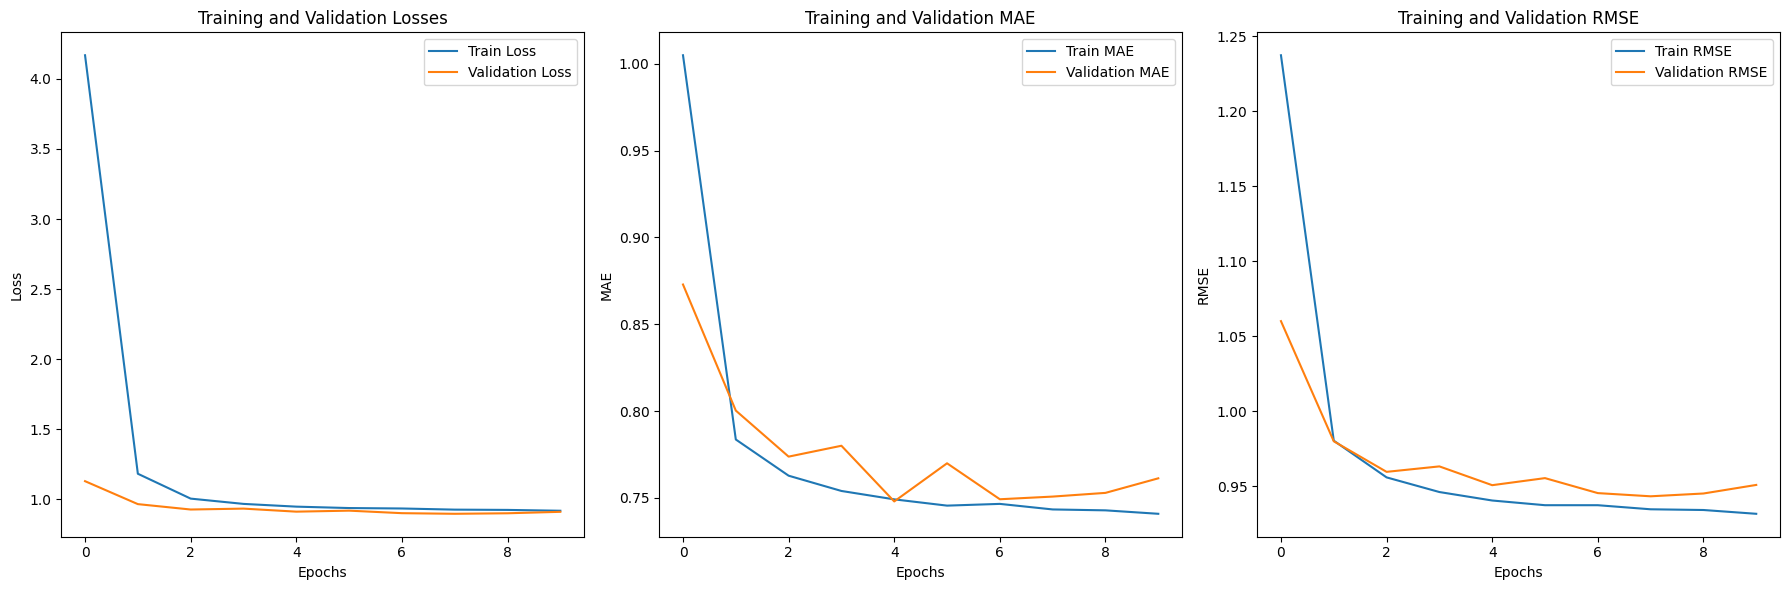

In [23]:
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(train_maes, label='Train MAE')
plt.plot(val_maes, label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.title('Training and Validation MAE')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(train_rmses, label='Train RMSE')
plt.plot(val_rmses, label='Validation RMSE')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.title('Training and Validation RMSE')
plt.legend()

plt.tight_layout()
plt.show()

In [24]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    total_mae = 0
    total_rmse = 0
    with torch.no_grad():
        for batch in dataloader:
            user, event, target = batch[:, 0].to(device), batch[:, 1].to(device), batch[:, 2].float().to(device)
            output = model(user, event).squeeze()
            loss = criterion(output, target)
            total_loss += loss.item()

            # Calculate MAE and RMSE for test set
            mae = torch.abs(output - target).mean().item()
            rmse = torch.sqrt(((output - target) ** 2).mean()).item()
            total_mae += mae
            total_rmse += rmse
    
    avg_loss = total_loss / len(dataloader)
    avg_mae = total_mae / len(dataloader)
    avg_rmse = total_rmse / len(dataloader)
    return avg_loss, avg_mae, avg_rmse

In [25]:
test_loss, test_mae, test_rmse = evaluate(model, test_dataloader, criterion, device)
print(f"\nTest Loss: {test_loss:.4f} | Test MAE: {test_mae:.4f} | Test RMSE: {test_rmse:.4f}")


Test Loss: 0.9082 | Test MAE: 0.7592 | Test RMSE: 0.9492
